## This notebook is used to analyse the intensity evaluation of lane-changing interactions in highD

In [1]:
import sys
import glob
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
font = {'family' : 'Arial',
        'size'   : 9}
plt.rc('font', **font)
plt.rcParams['mathtext.fontset'] = 'stix' #dejavuserif
def to_grayscale(fig):
    fig.canvas.draw()
    img = np.array(fig.canvas.renderer.buffer_rgba())
    grayscale_img = np.dot(img[..., :3], [0.2989, 0.5870, 0.1140])
    fig_gray, ax_gray = plt.subplots(figsize=(fig.get_size_inches()), dpi=fig.dpi)
    ax_gray.imshow(grayscale_img, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
    ax_gray.axis('off')  # Turn off the axis
    ax_gray.set_title('Grayscale plot')
sys.path.append('../../')
from DataProcessing.utils.coortrans import coortrans
coortrans = coortrans()
from Demonstration.demonstration_utils import *


path_raw = '../../Data/RawData/'
path_processed = '../../Data/ProcessedData/'
path_input = '../../Data/InputData/'
path_output = '../../Data/OutputData/'
fig_path = r'C:/SURFdrive/PhD progress/PhDResearch/4_Conflict/AMAR/Figures/'

### Read data

In [2]:
interaction_cases = pd.read_csv(path_output + 'intensity_evaluation/highD_interactive_LC.csv')

conflict_cases = pd.read_csv(path_output + 'intensity_evaluation/highD_conflict_LC.csv')
conflict_cases[['frame_start','frame_end']] = interaction_cases.set_index('lc_id').loc[conflict_cases['lc_id']][['frame_start','frame_end']].values.astype(int)
conflict_cases['duration'] = conflict_cases['frame_end'] - conflict_cases['frame_start']
conflict_cases.loc[conflict_cases['avg_intensity'].isna(), 'avg_intensity'] = 1.
conflict_cases.loc[conflict_cases['avg_TTC'].isna(), 'avg_TTC'] = np.inf

conflicts = pd.read_hdf(path_output + 'intensity_evaluation/highD_conflict_LC_data.h5', key='data')

### Spatial distribution of target vehicles

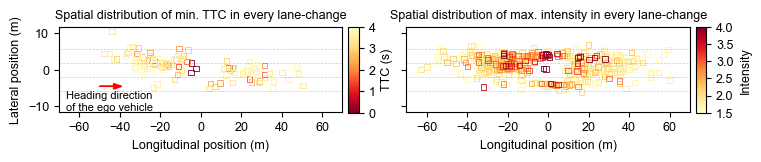

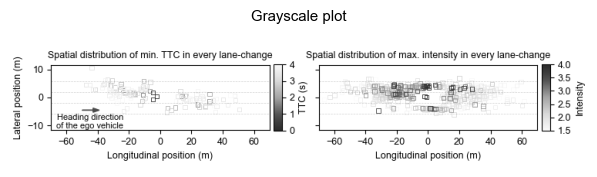

In [7]:
conflicts_view_i = coortrans.transform_coor(conflicts, view='i')
metadatafiles =  sorted(glob.glob(path_raw + 'highD/RecordingMetadata/*.csv'))
metadata = []
for metadatafile in metadatafiles:
    df = pd.read_csv(metadatafile)
    metadata.append(df)
metadata = pd.concat(metadata).set_index('id')

lane_width_list = []
for idx in metadata.index:
    lane_markings = [float(y) for lane in ['lowerLaneMarkings','upperLaneMarkings'] for y in metadata.loc[idx][lane].split(';')]
    lane_markings = np.sort(lane_markings)
    lane_widths = np.diff(lane_markings)
    lane_width_list.append(np.sort(lane_widths)[:-1])
lane_width_list = np.concatenate(lane_width_list)
avg_lane_width = np.mean(lane_width_list)


fig, axes = plt.subplots(1, 2, figsize=(7.5,1.8), sharex=True, sharey=True, constrained_layout=True)
for ax in axes:
    ax.plot([-70, 70], [avg_lane_width*0.5, avg_lane_width*0.5], 'k--', lw=0.5, alpha=0.2)
    ax.plot([-70, 70], [-avg_lane_width*0.5, -avg_lane_width*0.5], 'k--', lw=0.5, alpha=0.2)
    ax.plot([-70, 70], [avg_lane_width*1.5, avg_lane_width*1.5], 'k--', lw=0.5, alpha=0.2)
    ax.plot([-70, 70], [-avg_lane_width*1.5, -avg_lane_width*1.5], 'k--', lw=0.5, alpha=0.2)

test = conflicts_view_i.loc[conflicts_view_i.groupby('lc_id')['TTC'].idxmin()]
test = test[test['TTC']<=4].sort_values('TTC')
axes[0].scatter(test['y_j'], test['x_j'], marker='s', s=15, lw=0.6,
                edgecolors=mpl.cm.YlOrRd_r(test['TTC']/4), facecolors='none')
axes[0].arrow(-50, -4.5, 7, 0, head_width=1.5, head_length=4, fc='r', ec='r')
axes[0].text(-45, -avg_lane_width*3, 'Heading direction\nof the ego vehicle', fontsize=8, ha='center', va='bottom')
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='YlOrRd_r'), ax=axes[0], pad=0.02, shrink=0.5, aspect=8, ticks=[0, 1, 2, 3, 4], label='TTC (s)')
axes[0].set_xlim(-70, 70)
axes[0].set_ylim(-avg_lane_width*3, avg_lane_width*3)
axes[0].set_xlabel('Longitudinal position (m)')
axes[0].set_ylabel('Lateral position (m)')
axes[0].set_aspect(1.8)
axes[0].set_title('Spatial distribution of min. TTC in every lane-change', fontsize=9)

test = conflicts_view_i.loc[conflicts_view_i.groupby('lc_id')['n_hat'].idxmax()]
test = test[test['n_hat']>=25].sort_values('n_hat')
axes[1].scatter(test['y_j'], test['x_j'], marker='s', s=15, lw=0.6,
                edgecolors=mpl.cm.YlOrRd((np.log10(test['n_hat'])-1.5)/2.5), facecolors='none')
fig.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=1.5, vmax=4), cmap='YlOrRd'), ax=axes[1], pad=0.02, shrink=0.5, aspect=8, ticks=[1.5, 2, 2.5, 3, 3.5, 4], label='Intensity')
axes[1].set_xlabel('Longitudinal position (m)')
axes[1].set_aspect(1.8)
axes[1].set_title('Spatial distribution of max. intensity in every lane-change', fontsize=9)


to_grayscale(fig)

In [8]:
fig.savefig(fig_path + 'highD_conflict_distribution.pdf', dpi=600, bbox_inches='tight')

### Summary of intensity evaluation

In [6]:
num_interactions = interaction_cases['lc_id'].nunique()
print(f'There are {num_interactions} lane-changes in the highD dataset, of which {conflict_cases['lc_id'].nunique()} involve conflicts, at a rate of {conflict_cases['lc_id'].nunique()/num_interactions*100:.2f}%.')

num_conflicts = conflict_cases.shape[0]
print(f'In these conflicting lane-changes, {num_conflicts} pairwise interactions have at least 0.5 second identified as a conflict in the highD dataset.')

num_conflicts = conflict_cases[(conflict_cases['TTC'])&(conflict_cases['Unified'])].shape[0]
print(f'{num_conflicts} of the interactions have at least 1 second identified as a conflict by both TTC and Unified')

num_conflicts = conflict_cases[(conflict_cases['TTC'])&(~conflict_cases['Unified'])].shape[0]
print(f'{num_conflicts} of the interactions have at least 1 second identified as a conflict by TTC only')

num_conflicts = conflict_cases[(~conflict_cases['TTC'])&(conflict_cases['Unified'])].shape[0]
print(f'{num_conflicts} of the interactions have at least 1 second identified as a conflict by Unified only')

There are 13336 lane-changes in the highD dataset, of which 555 involve conflicts, at a rate of 4.16%.
In these conflicting lane-changes, 586 pairwise interactions have at least 0.5 second identified as a conflict in the highD dataset.
53 of the interactions have at least 1 second identified as a conflict by both TTC and Unified
19 of the interactions have at least 1 second identified as a conflict by TTC only
514 of the interactions have at least 1 second identified as a conflict by Unified only


In [7]:
intensity_lower = [0., 1.5,2.0,2.5,3.0,3.5,4.0,4.5]
intensity_upper = [1.5, 2.0,2.5,3.0,3.5,4.0,4.5,5.0]
folder_names = [f'intensity_{l}-{u}' for l,u in zip(intensity_lower, intensity_upper)]
features2save = ['location','veh_id_i','veh_id_j','frame_start','frame_end','avg_intensity','avg_TTC']
summary_table = []
for folder_name, intensity_l, intensity_u in zip(folder_names, intensity_lower, intensity_upper):
    summary_df = pd.DataFrame([[0.,0.,'', 0, 0, 0, 0, np.nan, np.nan]]*3, 
                              columns=['intensity_lower','intensity_upper','specification','num_conflicts','location','veh_id_i','veh_id_j','avg_intensity','avg_TTC'])
    summary_df['intensity_lower'] = intensity_l
    summary_df['intensity_upper'] = intensity_u
    use_cases = conflict_cases[(conflict_cases['avg_intensity']>=intensity_l)&(conflict_cases['avg_intensity']<intensity_u)].copy()

    summary_df.loc[0,'specification'] = 'Both TTC and Unified'
    use_case = use_cases[(use_cases['TTC'])&(use_cases['Unified'])]
    summary_df.loc[0,'num_conflicts'] = len(use_case)
    if summary_df.loc[0,'num_conflicts'] > 0:
        dis2median = np.sum((use_case[['avg_intensity','avg_TTC']] - use_case[['avg_intensity','avg_TTC']].median())**2, axis=1)
        summary_df.loc[0, features2save] = use_case.loc[dis2median.idxmin()][features2save].values

    summary_df.loc[1,'specification'] = 'TTC only'
    use_case = use_cases[(use_cases['TTC'])&(~use_cases['Unified'])]
    summary_df.loc[1,'num_conflicts'] = len(use_case)
    if summary_df.loc[1,'num_conflicts'] > 0:
        dist2median = np.sum((use_case[['avg_intensity','avg_TTC']] - use_case[['avg_intensity','avg_TTC']].median())**2, axis=1)
        summary_df.loc[1, features2save] = use_case.loc[dist2median.idxmin()][features2save].values

    summary_df.loc[2,'specification'] = 'Unified only'
    use_case = use_cases[(~use_cases['TTC'])&(use_cases['Unified'])]
    summary_df.loc[2,'num_conflicts'] = len(use_case)
    if summary_df.loc[2,'num_conflicts'] > 0:
        dist2median = np.sum((use_case[['avg_intensity','avg_TTC']] - use_case[['avg_intensity','avg_TTC']].median())**2, axis=1)
        summary_df.loc[2, features2save] = use_case.loc[dist2median.idxmin()][features2save].values

    summary_table.append(summary_df)

summary_table = pd.concat(summary_table).reset_index(drop=True)
summary_table.to_csv(path_output + 'intensity_evaluation/highD_conflict_LC_to_visualse.csv', index=False)

In [9]:
summary_table.sort_values(by=['specification','intensity_lower'])

,intensity_lower,intensity_upper,specification,num_conflicts,location,veh_id_i,veh_id_j,avg_intensity,avg_TTC,frame_start,frame_end
0,0.0,1.5,Both TTC and Unified,4,1,252438,252392,1.481942,3.030299,2509934.0,2510446.0
3,1.5,2.0,Both TTC and Unified,25,1,471668,471667,1.712645,3.432307,4706788.0,4706951.0
6,2.0,2.5,Both TTC and Unified,15,1,450168,450171,2.289753,3.543298,4500680.0,4500818.0
9,2.5,3.0,Both TTC and Unified,8,1,350404,350405,2.652416,3.203783,3502048.0,3502088.0
12,3.0,3.5,Both TTC and Unified,0,0,0,0,NaN,NaN,NaN,NaN
15,3.5,4.0,Both TTC and Unified,0,0,0,0,NaN,NaN,NaN,NaN
18,4.0,4.5,Both TTC and Unified,0,0,0,0,NaN,NaN,NaN,NaN
21,4.5,5.0,Both TTC and Unified,1,1,260496,260535,4.995348,-1.000000,2602158.0,2602227.0
1,0.0,1.5,TTC only,19,1,261629,261623,0.000000,3.622547,2606569.0,2606648.0
4,1.5,2.0,TTC only,0,0,0,0,NaN,NaN,NaN,NaN


In [10]:
summary_table.groupby('specification')['num_conflicts'].sum(), summary_table.groupby('specification')['num_conflicts'].sum().sum()

(specification
 Both TTC and Unified     53
 TTC only                 19
 Unified only            514
 Name: num_conflicts, dtype: int64,
 586)

In [11]:
summary_table.groupby(['intensity_lower','intensity_upper'])['num_conflicts'].sum(), summary_table.groupby(['intensity_lower','intensity_upper'])['num_conflicts'].sum().sum()

(intensity_lower  intensity_upper
 0.0              1.5                142
 1.5              2.0                366
 2.0              2.5                 60
 2.5              3.0                 12
 3.0              3.5                  4
 3.5              4.0                  1
 4.0              4.5                  0
 4.5              5.0                  1
 Name: num_conflicts, dtype: int64,
 586)

### Power-law distribution of intensity

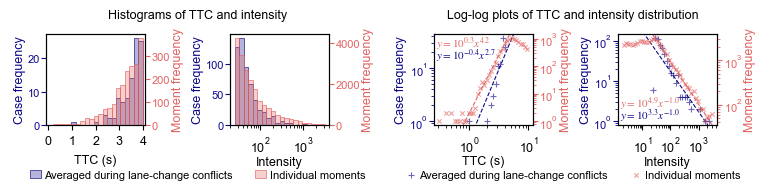

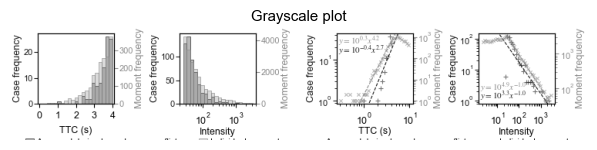

In [12]:
def rgb_color(color, alpha=1.):
    return (color[0], color[1], color[2], alpha)

def trendline(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    return p
    
fig, axes = plt.subplots(1,5,figsize=(7.5,1.45), constrained_layout=True, gridspec_kw={'width_ratios': [1,1,0.05,1,1]})
axes[2].axis('off')
cmap = mpl.cm.plasma

conflict_cases['avg_TTC'].hist(bins=np.linspace(0.2, 4.0, 21), 
                               fc=rgb_color(cmap(0.), 0.3), ec=rgb_color(cmap(0.), 0.9), 
                               lw=0.5, label='Averaged during lane-change conflicts', grid=False, ax=axes[0])
ax0 = axes[0].twinx()
conflicts['TTC'].hist(bins=np.linspace(0.2, 4.0, 21), 
                      fc=rgb_color(cmap(0.6), 0.3), ec=rgb_color(cmap(0.6), 0.9), 
                      lw=0.5, label='Individual moments', grid=False, ax=ax0)
axes[0].set_xlabel('TTC (s)', labelpad=5)
axes[0].set_ylabel('Case frequency', labelpad=1)
ax0.set_ylabel('Moment frequency', labelpad=1)
axes[0].yaxis.label.set_color(cmap(0.))
ax0.yaxis.label.set_color(cmap(0.6))
axes[0].tick_params(axis='y', colors=cmap(0.), labelsize=8, pad=1)
ax0.tick_params(axis='y', colors=cmap(0.6), labelsize=8, pad=1)
axes[0].set_xlim(-0.1, 4.1)
axes[0].set_xticks([0,1,2,3,4])

axes[1].set_xscale('log')
(10**conflict_cases['avg_intensity']).hist(bins=[10**i for i in np.linspace(np.log10(25),3.5,21)],
                                     fc=rgb_color(cmap(0.), 0.3), ec=rgb_color(cmap(0.), 0.9),
                                     lw=0.5, label='Averaged during lane-change conflicts', grid=False, ax=axes[1])
ax1 = axes[1].twinx()
conflicts['n_hat'].hist(bins=[10**i for i in np.linspace(np.log10(25),3.5,21)],
                        fc=rgb_color(cmap(0.6), 0.3), ec=rgb_color(cmap(0.6), 0.9),
                        lw=0.5, label='Individual moments', grid=False, ax=ax1)
axes[1].set_xlabel('Intensity', labelpad=0)
axes[1].set_ylabel('Case frequency', labelpad=1)
ax1.set_ylabel('Moment frequency', labelpad=1)
axes[1].yaxis.label.set_color(cmap(0.))
ax1.yaxis.label.set_color(cmap(0.6))
axes[1].tick_params(axis='y', colors=cmap(0.), labelsize=8, pad=1)
ax1.tick_params(axis='y', colors=cmap(0.6), labelsize=8, pad=1)

handle1, label1 = axes[0].get_legend_handles_labels()
handle2, label2 = ax0.get_legend_handles_labels()
ax_legend = fig.add_axes([0., 0., 0.5, 1])
ax_legend.axis('off')
ax_legend.legend(handle1+handle2, label1+label2, ncol=2, bbox_to_anchor=(0.5, -0.1), loc='lower center',
                 fontsize=8, frameon=False, handlelength=1., handletextpad=0.3, borderaxespad=0.3, borderpad=0.3)
ax_legend.set_title('Histograms of TTC and intensity', fontsize=9)


bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
ax3 = axes[3].twinx()
hist, bins = np.histogram(conflicts['TTC'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
ax3.scatter(bins, hist, s=10, color=cmap(0.6), marker='x', lw=0.8, alpha=0.6, label='Individual moments')
bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
hist, bins = np.histogram(conflict_cases['avg_TTC'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
axes[3].scatter(bins, hist, s=15, color=cmap(0.), marker='+', lw=0.8, alpha=0.6, label='Averaged during lane-change conflicts')
axes[3].loglog()
ax3.loglog()
ylim = ax3.get_ylim()
ax3.set_ylim(ylim[0], ylim[1])
ylim = axes[3].get_ylim()
axes[3].set_ylim(ylim[0], ylim[1])
axes[3].set_xlabel('TTC (s)', labelpad=0)
axes[3].set_ylabel('Case frequency', labelpad=1)
ax3.set_ylabel('Moment frequency', labelpad=1)
axes[3].yaxis.label.set_color(cmap(0.))
ax3.yaxis.label.set_color(cmap(0.6))
axes[3].tick_params(axis='y', which='both', colors=cmap(0.), labelsize=8, pad=1)
ax3.tick_params(axis='y', which='both', colors=cmap(0.6), labelsize=8, pad=1)
hist_conflict_cases = hist.copy()


bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
hist, bins = np.histogram(conflicts['TTC'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
bins, hist = bins[hist_conflict_cases>0], hist[hist_conflict_cases>0]
tl = trendline(np.log10(bins), np.log10(hist))
bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
ax3.plot(bins, 10**tl(np.log10(bins)), ls='--', color=cmap(0.6), lw=0.8)
ax3.text(0.02, 0.98, "$y=10^{%.1f}x^{%.1f}$"%(tl[0],tl[1]), fontsize=8, ha='left', va='top', transform=ax3.transAxes, color=cmap(0.6))
bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
hist, bins = np.histogram(conflict_cases['avg_TTC'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
bins, hist = bins[hist_conflict_cases>0], hist_conflict_cases[hist_conflict_cases>0]
tl = trendline(np.log10(bins), np.log10(hist))
bins = [10**i for i in np.linspace(np.log10(0.3),np.log10(10),41)]
axes[3].plot(bins, 10**tl(np.log10(bins)), ls='--', color=cmap(0.), lw=0.8)
axes[3].text(0.02, 0.85, "$y=10^{%.1f}x^{%.1f}$"%(tl[0],tl[1]), fontsize=8, ha='left', va='top', transform=axes[3].transAxes, color=cmap(0.))


bins = [10**i for i in np.linspace(np.log10(2), 3.5, 41)]
ax4 = axes[4].twinx()
hist, bins = np.histogram(conflicts['n_hat'], bins=bins)
ax4.scatter((bins[:-1]+bins[1:])/2, hist, s=10, color=cmap(0.6), marker='x', lw=0.8, alpha=0.6)
hist, bins = np.histogram(10**conflict_cases['avg_intensity'], bins=bins)
axes[4].scatter((bins[:-1]+bins[1:])/2, hist, s=15, color=cmap(0.), marker='+', lw=0.8, alpha=0.6)
axes[4].loglog()
ax4.loglog()
ylim = ax4.get_ylim()
ax4.set_ylim(ylim[0], ylim[1])
ylim = axes[4].get_ylim()
axes[4].set_ylim(ylim[0], ylim[1])
axes[4].set_xlabel('Intensity', labelpad=0)
axes[4].set_ylabel('Case frequency', labelpad=1)
ax4.set_ylabel('Moment frequency', labelpad=1)
axes[4].yaxis.label.set_color(cmap(0.))
ax4.yaxis.label.set_color(cmap(0.6))
axes[4].tick_params(axis='y', which='both', colors=cmap(0.), labelsize=8, pad=1)
ax4.tick_params(axis='y', which='both', colors=cmap(0.6), labelsize=8, pad=1)
ax4.xaxis.get_minor_locator().set_params(numticks=10)
hist_conflict_cases = hist.copy()

bins = [10**i for i in np.linspace(np.log10(2), 3.5, 41)]
hist, bins = np.histogram(conflicts['n_hat'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
bins, hist = bins[hist_conflict_cases>0], hist[hist_conflict_cases>0]
tl = trendline(np.log10(bins), np.log10(hist))
bins = [10**i for i in np.linspace(np.log10(2), 3.5, 41)]
ax4.plot(bins, 10**tl(np.log10(bins)), ls='--', color=cmap(0.6), lw=0.8)
ax4.text(0.02, 0.15, "$y=10^{%.1f}x^{%.1f}$"%(tl[0],tl[1]), fontsize=8, ha='left', va='bottom', transform=ax4.transAxes, color=cmap(0.6))
bins = [10**i for i in np.linspace(np.log10(2), 3.5, 41)]
hist, bins = np.histogram(10**conflict_cases['avg_intensity'], bins=bins)
bins = (bins[:-1]+bins[1:])/2
bins, hist = bins[hist_conflict_cases>0], hist_conflict_cases[hist_conflict_cases>0]
tl = trendline(np.log10(bins), np.log10(hist))
bins = [10**i for i in np.linspace(np.log10(2), 3.5, 41)]
axes[4].plot(bins, 10**tl(np.log10(bins)), ls='--', color=cmap(0.), lw=0.8)
axes[4].text(0.02, 0.02, "$y=10^{%.1f}x^{%.1f}$"%(tl[0],tl[1]), fontsize=8, ha='left', va='bottom', transform=axes[4].transAxes, color=cmap(0.))

handle1, label1 = axes[3].get_legend_handles_labels()
handle2, label2 = ax3.get_legend_handles_labels()
ax_legend = fig.add_axes([0.5, 0., 0.5, 1])
ax_legend.axis('off')
ax_legend.legend(handle1+handle2, label1+label2, ncol=2, bbox_to_anchor=(0.5, -0.1), loc='lower center',
                 fontsize=8, frameon=False, handlelength=1., handletextpad=0.3, borderaxespad=0.3, borderpad=0.3)
ax_legend.set_title('Log-log plots of TTC and intensity distribution', fontsize=9)

to_grayscale(fig)

In [13]:
fig.savefig(fig_path + 'conflict_intensity_hist.pdf', dpi=600, bbox_inches='tight')